# Setup

In [34]:
#! pip install pandas-datareader
#! pip install pmdarima
#! pip install plotly
#!pip install dash-bootstrap-components
import numpy as np
from pandas_datareader import DataReader # pip install pandas-datareader
from pandas_datareader import data
from datetime import datetime
from pmdarima.arima import *
from pmdarima import preprocessing
from scipy import stats
from scipy.stats import skew

from statsmodels import api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas as pd
import pmdarima as pm
import plotly.graph_objects as go
import plotly.express as px
from plotly.tools import mpl_to_plotly 


In [35]:
start = pd.to_datetime('2010-01-01') # in YYYY-MM-DD format
end = pd.to_datetime('2018-01-31')
ts = data.DataReader('NDAQ', 'yahoo', start , end) # here 'yahoo' is the API to yahoo
ts_cut = data.DataReader('NDAQ', 'yahoo', '2003-06-01' , 'today')
train = ts.Close.loc['2010-01-01':'2018-01-01']
test = ts.Close.loc['2018-01-01':'2018-01-31']
test_7 = ts.Close.loc['2017-12-20': '2018-01-01']
test_31 = ts.Close.loc['2017-11-15':'2018-01-01']
two_month = ts.Close.loc['2017-10-15':'2018-01-01']
cut = ts_cut.Close.loc['2003-06-01':'2021-04-01']

In [36]:
ts_cut["Color"] = np.where(ts_cut["Close"]>10, 'red', 'green')

total = px.line(ts.Close, x=[ts.Close.index], y="Close", title="NASDAQ Closing Values: 2003 - 2021")
total.add_trace(
    go.Scatter(name='Cut-Off',
           x=ts_cut.index,
           y=ts_cut['Close'],
           marker_color=ts_cut['Color']))

total.add_vline(x='2010-01-01', line_width=3, line_dash="dash", line_color="green")
total.add_vline(x='2018-01-01', line_width=3, line_dash="dash", line_color="green")
total.data[0].name= "Sample Data"
total.show()

# Normalisation

In [37]:
ts.Close.skew()

0.481740296905183

In [38]:
# put all normalisation functions before modelling

In [39]:
#transformed data
boxCoxData, boxCox_lambda = stats.boxcox(train)
boxCoxSkew = skew(boxCoxData)

#we want to compare their absolute skewness 
if(boxCoxSkew < 0):
    boxCoxSkew = boxCoxSkew * -1

johnsonData, johnson_lambda = stats.yeojohnson(train)
johnsonSkew = skew(johnsonData)

if(johnsonSkew < 0):
    johnsonSkew = johnsonSkew * -1

#to show which is less skewed 
print(johnsonSkew)
print(boxCoxSkew)

0.043066305774378665
0.0391631256848633


In [40]:
#so we know what method was used, so we can reverse later. 
normaliseMethod = "neither"

if(johnsonSkew < boxCoxSkew):
    normalised_Data = johnsonData
    fitted_lambda = johnson_lambda
    normaliseMethod = "johnson"
    
#being == doesn't really matter same either way
elif(boxCoxSkew <= johnsonSkew):
    normalised_Data = boxCoxData
    fitted_lambda = boxCox_lambda
    normaliseMethod = "boxcox"

skew(normalised_Data)
#print(fitted_lambda)

0.0391631256848633

In [41]:
actual = px.line(ts.Close, x=ts.index, y="Close", title="NASDAQ Closing Values: 2010 - 2018")
actual.show()

actual_hist = px.histogram(ts, title="Normal Distribution", x="Close", width=800, height=500)
actual_hist.show()

bc = pd.DataFrame(normalised_Data, columns = ['Close'])
bc = px.histogram(bc, x="Close")
bc.show()
bc_plot = px.line(normalised_Data, x=train.index, y=normalised_Data, title="Box-Cox Transformed Data")
bc_plot.data[0].line.color = 'green'
bc_plot.show()

# Modelling Functions

## Stationarity Tests:

In [42]:
def testLevelStationarity(ts):
    adf_result = sm.tsa.stattools.adfuller(ts)
    kpps_result = sm.tsa.stattools.kpss(ts)
    print(f'ADF p-value: {adf_result[1]}')
    print(f'KPPS p-value: {kpps_result[1]}')

    d = ndiffs(ts, test='kpss')
    d += ndiffs(ts, test='adf')
    d += ndiffs(ts, test='pp')
    
    return int(d/3)

In [43]:
testLevelStationarity(normalised_Data)

ADF p-value: 0.8794848360564136
KPPS p-value: 0.01


C:\Users\Oisin Tong\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

C:\Users\Oisin Tong\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




0

## Seasonal Tests:

In [44]:
def seasonal_tests(data):
     
    result1 = pm.arima.nsdiffs(data, m=7, test='ch')
    
    print("CH results: " + str(result1))
    
    result2 = pm.arima.nsdiffs(data, m=7, test='ocsb')
    
    print("OCSB results: " + str(result2))
    
    return int((result1+result2)/2)


In [45]:
seasonal_tests(normalised_Data)

CH results: 0
OCSB results: 0


0

## Lag Period:

In [46]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame (diff,columns=['Difference'])

In [47]:
def find_lag_period(data):
    
    fig = px.line(ts.Close, x=[ts.Close.index], y="Close")
    fig.add_vline(x='2010-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2011-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2012-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2013-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2014-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2015-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2016-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2017-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2018-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.show()
    
    adf_test = ADFTest(alpha = 0.05)
    
    test = list()
    lags = [365, 182, 90, 30, 14]
    
    # original data
    test.append(adf_test.should_diff(data))
    print(test[0])
    
    # year lag
    test.append(adf_test.should_diff(difference(data, 365)))
    print(test[1])
    
    # six months lag
    test.append(adf_test.should_diff(difference(data, 182))) 
    print(test[2])
    
    # three months lag 
    test.append(adf_test.should_diff(difference(data, 90)))
    print(test[3])
    
    # one month lag 
    test.append(adf_test.should_diff(difference(data, 30)))
    print(test[4])
    
    # fortnight lag
    test.append(adf_test.should_diff(difference(data, 14))) 
    print(test[5])
    
    # finds the first lag that doesn't need to be differenced
    for i in range(6):
        if (test[i][1] == False):
            return int(lags[i])
        
    return -1

In [48]:
print(find_lag_period(normalised_Data))
print(find_lag_period(ts.Close))

(0.08966768756968181, True)
(0.45042711876766006, True)
(0.08009108397189417, True)
(0.01002064977478713, False)
(0.01, False)
(0.01, False)
30


(0.4558148391589999, True)
(0.35368951535350657, True)
(0.030428205122578645, False)
(0.01, False)
(0.01, False)
(0.01, False)
90


## AR & MA Tests

In [49]:
def getAicBicHqic(dataset, arimaOrder, seasonalOrder):
    
    try:
        model = sm.tsa.statespace.SARIMAX(dataset, order = arimaOrder, seasonal_order=seasonalOrder).fit(disp=False)

        aic = model.aic
        bic = model.bic
        hqic = model.hqic
        
    
    except:
        pass
    
    return aic, bic, hqic

In [50]:
def evaluateSarimaModels(dataset, pVals, dVal, qVals, seasonalPVals, seasonalDval, seasonalQVals, m):
    
    L = []
    for p in pVals:
        for q in qVals:
            for seasonalP in seasonalPVals:
                for seasonalQ in seasonalQVals:
                    try:
                        order=(p,dVal,q)
                        seasonalOrder = (seasonalP, seasonalDval, seasonalQ, m)
                        
                        model = sm.tsa.statespace.SARIMAX(dataset, order = order, seasonal_order=seasonalOrder).fit(disp=False)

                        data = [[model, (p,dVal,q), (seasonalP, seasonalDval, seasonalQ, m), model.aic, model.bic, model.hqic, model.mse, model.test_heteroskedasticity(None)[0][0]]]
                        dd = pd.DataFrame(data = data, columns = ['model','Order', 'SeasonalOrder', 'Aic', 'Bic', 'Hqic', 'Mse', 'heteroskedasticity'])
                        L.append(dd)
                    except:
                        continue
    df = pd.concat(L, ignore_index=True)
    return df



In [51]:
df = evaluateSarimaModels(normalised_Data, [0,1], 1, [0,1], [0,1], 0, [0,1], 7)

C:\Users\Oisin Tong\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Oisin Tong\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [52]:
def sarima_model (data):
#train_test_split

    
    stepwise_model_7 = auto_arima(data, start_p=1, start_q=1,
                           max_p=1, max_q=1, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=0,trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    
    return stepwise_model_7

In [53]:
orig_model_7 = sarima_model(train)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=3391.908, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3396.263, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3391.728, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3391.279, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3399.293, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3389.633, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3391.318, Time=0.40 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3382.212, Time=1.68 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=3382.193, Time=3.00 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=3387.240, Time=0.87 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=3378.207, Time=11.62 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=3382.114, Time=7.02 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=3384.926, Time=2.92 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=3378.870, Time=14.84 sec
 ARIMA(1,1,0)(2,0,2)[7] interce

In [54]:
orig_pred_7 = orig_model_7.predict_in_sample(start=len(train)-7, ends=len(train))
orig_pred_31 = orig_model_7.predict_in_sample(start=len(train)-31, ends=len(train))
orig_pred_total = orig_model_7.predict_in_sample(start=1, ends=len(ts.Close))
orig_pred_oos = orig_model_7.predict(31)

In [55]:
#reverse
#restored_Data = (normalised_future_forecast*fitted_lambda +1)**(1/fitted_lambda)

In [56]:
#evaluation of model fit
#boxljung test
#model_df is p+q
#m is seasonal period
#change boxpierce to true if you want to also run that test
#lbVal is the Ljung-Box test statistic and pVal is its p value
def getBoxLjung(data, lags, model_df, m):
    #demean the data
    demeanedData = data.sub(data.mean())
    lbVal, pVal = statsmodels.stats.diagnostic.acorr_ljungbox(demeanedData, lags, boxpierce = False, model_df = model_df, period = m)
    
    return lbVal, pVal
    

In [57]:
#Pass a fitted model
#returns 
#JBVal = Jarque-Bera test statistic
#JBPVal = pvalue of the test statistic
def getJarqueBera(data):
    
    JBVal, JBPVal, skewness, kurtosis = statsmodels.stats.stattools.jarque_bera(data.resid)
    
    return JBVal, JBPVal, skewness, kurtosis

## Function to sort different models:


In [58]:
import csv
import statsmodels

#input is a dataframe full of models
#I assume that there is no column that represents the skewness of model
def add_skewness(df, dataset):
    skewness = []
    #loop to get summary table of every model, then get skewness
    
    #To iterate through the df and isolate the model
    len = df.index
    for i in len:

        summary_table = df.model[i].summary()

        table_csv = summary_table.as_csv();

        skewness.append(table_csv[table_csv.find('Skew')+20 : table_csv.find('Skew')+25])


        #reader object stores all data
#         reader = csv.reader(table_csv)
        #change to finds out what cell skewness is in
#         skewness.append(table_csv[11][3])
        i+=1
    #at this point, skewness array should be full
    df['skewness'] = skewness
    return df;


In [59]:
add_skewness(df,ts.Close)

,model,Order,SeasonalOrder,Aic,Bic,Hqic,Mse,heteroskedasticity,skewness
0,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(0, 0, 0, 7)",-13516.110755,-13510.503870,-13514.052647,0.002739,0.223362,-0.15
1,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(0, 0, 1, 7)",-13513.986867,-13502.773098,-13509.870652,0.002739,0.223393,-0.15
2,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 0, 0, 7)",-13514.109590,-13502.895821,-13509.993376,0.002739,0.223361,-0.15
3,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 0, 1, 7)",-13512.075912,-13495.255258,-13505.901590,0.002739,0.223302,-0.15
4,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 0, 0, 7)",-13539.749805,-13528.536036,-13535.633590,0.002739,0.228274,-0.26
5,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 0, 1, 7)",-13537.634409,-13520.813755,-13531.460086,0.002739,0.228346,-0.26
6,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(1, 0, 0, 7)",-13537.749739,-13520.929085,-13531.575417,0.002739,0.228274,-0.26
7,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(1, 0, 1, 7)",-13535.739756,-13513.312218,-13527.507326,0.002739,0.228260,-0.26
8,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 0, 0, 7)",-13541.035621,-13529.821852,-13536.919406,0.002739,0.229039,-0.26
9,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 0, 1, 7)",-13538.942093,-13522.121440,-13532.767771,0.002739,0.229118,-0.26


## Graphing some models:

In [60]:
model_i = [5,7,9]
model_i = df.shape[0]
print(model_i)

16


Predicted Vals of 0 : 
 [75.05000305 75.40000153 76.08999634 76.12999725 76.33999634 76.66999817
 76.83000183]

 Conf int: 
 [[2.97704317 3.01000237]
 [2.97916728 3.01212647]
 [2.98332088 3.01628006]
 [2.98356031 3.01651949]
 [2.98481484 3.01777403]
 [2.98677806 3.01973725]
 [2.98772635 3.02068554]] 



 Std Err: 
 [0.00840811 0.00840811 0.00840811 0.00840811 0.00840811 0.00840811
 0.00840811] 



 RMSE: 
 2.1925825388542866e-27 


Predicted Vals of 1 : 
 [75.05036878 75.39204266 76.08431457 76.13031911 76.33581    76.66311077
 76.82141346]

 Conf int: 
 [[2.97704321 3.01000678]
 [2.97911692 3.01208049]
 [2.98328467 3.01624823]
 [2.98356004 3.01652361]
 [2.98478768 3.01775125]
 [2.986735   3.01969857]
 [2.98767332 3.02063689]] 



 Std Err: 
 [0.00840923 0.00840923 0.00840923 0.00840923 0.00840923 0.00840923
 0.00840923] 



 RMSE: 
 3.3512200759551494e-05 


Predicted Vals of 2 : 
 [75.05       75.40006705 76.09004321 76.1299947  76.34003099 76.67005424
 76.83007215]

 Conf int: 
 [[2

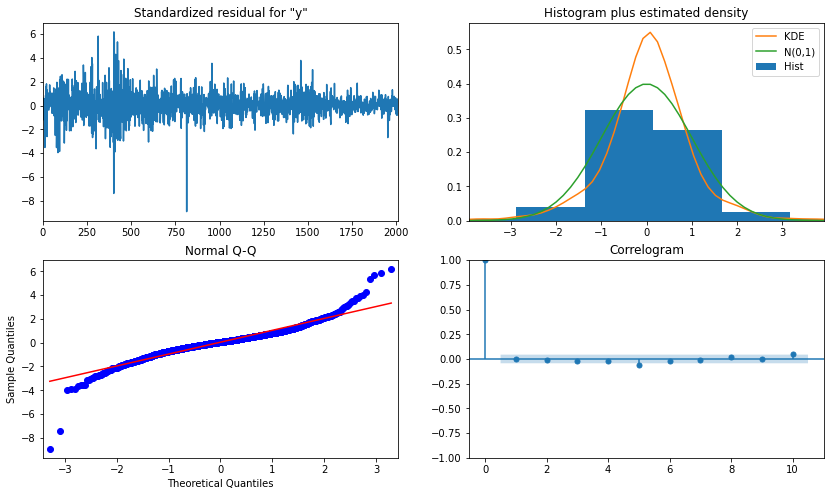

In [85]:
fig_7 = px.line(test_7, x=test_7.index, y=test_7, title="7-Day Prediction")
fig_7.data = []
fig_31 = px.line(test_31, x=test_31.index, y=test_31, title="31-Day Prediction")
fig_31.data = []
fig_total = px.line(ts.Close, x=ts.Close.index, y=ts.Close, title="2010-2018 Prediction")
fig_total.data = []
fig_forecast = px.line(ts.Close, x=ts.Close.index, y=ts.Close, title="2010-2018 Prediction")
fig_forecast.data = []

best_rmse_7 = 10000
best_rmse_31 = 10000
best_rmse_total = 10000

preds = [None] * 4



for x in range(model_i):
    
    model = df.model[x]
    pred_7 = model.get_prediction(start=len(normalised_Data)-6, end=len(normalised_Data))
    pred_31 = model.get_prediction(start=len(normalised_Data)-30, end=len(normalised_Data))
    pred_total = model.get_prediction(start=1, end=len(ts.Close))

    pred_7.predicted_mean = (pred_7.predicted_mean*fitted_lambda +1)**(1/fitted_lambda)
    pred_31.predicted_mean = (pred_31.predicted_mean*fitted_lambda +1)**(1/fitted_lambda)
    pred_total.predicted_mean = (pred_total.predicted_mean*fitted_lambda +1)**(1/fitted_lambda)

    
    print("Predicted Vals of", x, ": \n", pred_7.predicted_mean)
    #print(pred_7.summary_frame(alpha=0.05))   #mean isn't updated to reversed vals
    #conf_int = (model.conf_int(0.5)*fitted_lambda +1)**(1/fitted_lambda)   //don't think we should be reveresing the conf_int
    conf_int = (pred_7.conf_int(0.5))
    se = (pred_7.se_mean)
    rmse_7 = sm.tools.eval_measures.mse(test_7, pred_7.predicted_mean)

    rmse_31 = sm.tools.eval_measures.mse(test_31, pred_31.predicted_mean)

    rmse_total = sm.tools.eval_measures.mse(ts.Close, pred_total.predicted_mean)

    print('\n',"Conf int: \n",conf_int,'\n\n')
    print('\n',"Std Err: \n",se,'\n\n')
    print('\n',"RMSE: \n",rmse_7,'\n\n')

    if(rmse_7 < best_rmse_7):
        preds[0] = pred_7.predicted_mean
        best_rmse_7=rmse_7
    if(rmse_31 < best_rmse_31):
        preds[2] = pred_31.predicted_mean
        best_rmse_31=rmse_31
    if(rmse_total < best_rmse_total):
        preds[3] = pred_total.predicted_mean
        best_rmse_total=rmse_total
    

pred_oos = model.get_forecast(steps=31)
pred_oos.predicted_mean = (pred_oos.predicted_mean*fitted_lambda +1)**(1/fitted_lambda)


diag = model.plot_diagnostics(figsize=(14,8))


fig_7.add_scatter(x=test_7.index, y=test_7, name="Actual Values", mode='lines')
fig_7.add_scatter(x=test_7.index, y=orig_pred_7, name="Non-Transformed Prediction", mode='lines')
fig_7.add_scatter(x=test_7.index, y=preds[0], name="Box-Cox Prediction", mode='lines')


fig_31.add_scatter(x=test_31.index, y=test_31, name="Actual Values", mode='lines')
fig_31.add_scatter(x=test_31.index, y=orig_pred_31, name="Non-Transformed Prediction", mode='lines')
fig_31.add_scatter(x=test_31.index, y=preds[2], name="Box-Cox Prediction", mode='lines')

fig_total.add_trace(
    go.Scatter(name='Actual Values',
           x=ts.Close.index,
           y=train))
fig_total.add_trace(
    go.Scatter(name='Non-Transformed',
           x=ts.Close.index,
           y=orig_pred_total))
fig_total.add_trace(
    go.Scatter(name='Box-Cox',
           x=ts.Close.index,
           y=pred_total.predicted_mean))

fig_forecast.add_trace(
    go.Scatter(name='Actual Values',
           x=test.index,
           y=test))
fig_forecast.add_trace(
    go.Scatter(name='Non-Transformed',
           x=test.index,
           y=orig_pred_oos))
fig_forecast.add_trace(
    go.Scatter(name='Box-Cox',
           x=test.index,
           y=pred_oos.predicted_mean))


In [86]:
fig_7.show()
fig_31.show()
fig_total.show()
fig_forecast.show()

## Dash App

In [64]:
import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc

from pandas_datareader import DataReader # pip install pandas-datareader
from pandas_datareader import data

import pandas as pd
import pmdarima as pm
import plotly.graph_objects as go
import plotly.express as px


In [65]:
#set up app

app = dash.Dash()

In [99]:
# create a Dash layout
app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = dbc.Container(dbc.Jumbotron(
    [
        html.H1("Time Series Analysis on Stocks Prediction", className="display-3"),
        html.P(
            "Group 40 ",
            className="lead",
        ),
        html.Hr(className="my-2"),
    
        dbc.Card(
             [
                 dbc.CardBody(
                    [
                        html.H4("Introduction", className="intro-card"),
                        html.P(
                            "Creating well-fitting models which can accurately predict a time series is a complex challenge "
                            "in and of itself. On top of this, it's our team's first exposure to Data Science. "
                            "Because of this, we had to analyse our options and make some practical decisions from the very beginning. "
                            "First, we chose the NASDAQ as our time series to model. Being an index, the NASDAQ exhibits a relatively "
                            "stable set of values, which is vital for our purposes. "
                            "To this end, we also set our time period to be 2010-2018. Before 2010, we determined that values "
                            "would have little correlation with current ones. After 2018, the NASDAQ fluctuates immensely, so we "
                            "cut ensuing values to preserve integrity."
                            ,
                            className="intro-text",
                            ),
                        dcc.Graph(id = 'cut', figure = total),
                        dcc.Graph(id = 'actual', figure = actual)
                    ],
                    style={"width":"100%"},
                    )
                 ]
            ),
        
        dbc.Card(
             [
                 dbc.CardBody(
                    [
                        html.H4("Normalization", className="normalization-card"),
                        html.P(
                            "SARIMA models work best when applied to data-sets which conform to the properites of linear regression. "
                            "One such property is normal distribution. Given the upwards trend of our data we know that our time series "
                            "Is skewed towards the right, so it isn't normally distributed. "
                            "Therefore, our first step is to transform our data towards a normal distribution. "
                            "Our transformation methods were measured by the skewness value of the resutling data, and our "
                            "tests revealed the most succesful methods to be Box-Cox. "
                            "Below is the Box-Cox formula, and the resulting transformed data after applying Box-Cox to our "
                            "data set. Although it still isn't normally distributed, all progress towards normal distribution "
                            "helps with the modelling process.",


                            className="normalization-text",

                            ),
                        html.Img(src=app.get_asset_url('bc_formula.png'),title='Box Cox Formula',
                                 style={
                                    'textAlign': 'center'
                                    }),
                        dcc.Graph(id = 'bc_plot', figure = bc_plot)

                    ],
                    style={"width":"100%"},
                    )
                 ]
            ),
        
        dbc.Card(
             [
                 dbc.CardBody(
                    [
                        html.H4("Parameter Tests", className="modeling-card"),
                html.P(
                    "SARIMA takes a total of 7 parameters to tune the model to a given data set. "
                    "These parameters are (p,d,q) (P,D,Q)m ",
                    className="modeling-text",
                ),
                        
                html.H5("d"),
                html.P(
                    "d refers to the differencing term. Differencing is applied to a time-series to remove an overall trend "
                    " from the time series and make it stationary. "
                    "A stationary time series means that it's values are independent of the time of observation. "
                    "We used ADF (Augmented Dickey Fuller) and KPPS (Kwiatkowski-Phillips-Schmidt-Shin) tests to confirm that "
                    "differencing was requried for our time series, and to determine the optimal d value."
                    "These tests revealed that our optimal value for d is 1"
                    ,
                    className="d-text",
                ),
                        
                html.H5("m"),      
                html.P(
                    "m refers to the number of periods in a season. Given that our time series contains daily values, "
                    "we found m=7 to be an appropriate value, which is to say, weekly patterns."
                    ,
                    className="seasonal_lag-text",
                ),
                        
                html.H5("D"),      
                html.P(
                    "D refers to the seasonal differencing term. This depends on m, and relates to the trend found within a season. "
                    "The Canova-Hansen (CH) and Osborn, Chui, Smith, and Birchenhall (OCSB) tests are used to derive the "
                    "optimal D value, which turns out to be 0.",
                    className="seasonal_lag-text",
                ),
                        
                html.H5("p, q, P, Q"),      
                html.P(
                    "[p, q] refer to the auto-regressive and moving average parameter respectively. P, Q refer to their seasonal "
                    "equivalents. Our process for determining these values is to run a series of nested for-loops which iterate "
                    "through every possible combination of these values and combine them with the other predetermined parameters "
                    " and evaluate each resulting model using the metrics discussed in the below section."
                    ,
                    className="seasonal_lag-text",
                            ),
                        
                    ],
                    style={"width":"100%"},
                    )
                 ]
            ),
        
        dbc.Card(
             [
                 dbc.CardBody(
                    [
                        html.H4("Evaluating Models", className="evaluating_models-card"),
                html.P(
                    "SARIMA models contain a number of attributes which are indicitive of their integrity, " 
                    "For our evaluations, we used AIC, HQIC, heteroskedasticity and skewness, "
                    "with a priority of minimizing skewness and heteroskedasticity. "
                    "Following these comparisons, we retain a select number of models to proceed with.",
                    className="evaluating_models-text",
                            ),
                    ],
                    style={"width":"100%"},
                    )
                 ]
            ),

        
        dbc.Card(
             [
                 dbc.CardBody(
                    [
                        html.H4("Dash Implementation", className="dash_implementation-card"),
                html.P(
                    "In order to display the results derived from the models used throughout the project, our group decided to implement Dash, a Python framework for building web analytic applications. Dash allowed us to develop a customisable dashboard without having to code any HTML or CSS scripts. "
                    "Our Dash app is composed of two parts. The first part being the layout, which determines how the application will look. Within this app.layout section, components such as html.Div and dcc.Graph (dash_core_components) are used so to include headers and plots for our data. "
                    "The second part of this app is related to using callback functions, so that the dashboard is interactive and can be updated live. Functions within the @app.callback section filter the relevant data and update the plots."
                    "Finally once all components have been put in place, a local host server is set up upon which our dashboard is displayed, for the user to interact with in a much more pleasing environment than the Jupyter Notebook itself.",
                   
                    className="dash_implementation-text",
                            ),
                    ],
                    style={"width":"100%"},
                    )
                 ]
            ),
        
        dbc.Card(
             [
                 dbc.CardBody(
                    [
                        html.H4("Visualisation", className="vis-card"),
                html.P(
                    "With our models prepared, we are ready to visualise some results. Below is a 7-day and 31-day prediction "
                    "using various models.",
                   
                    className="vis-text",
                            ),
                    dcc.Graph(id = 'pred_7', figure = fig_7),
                    dcc.Graph(id = 'pred_31', figure = fig_31),
                    html.Img(src=app.get_asset_url('diag.png')),
                html.P(
                    "The residual plot graphs the difference between the predicted value and the true value. If the residual "
                    "plot displays a pattern, it indicates that there is an aspect of the data which is still not accounted for "
                    "in our model. Our residual plot is random, which suggests that is not the case for our model."
                    "using various models."
                    "This theory is supported by the histogram and density plot of our residual, which is normally-distributed. ",
                    
                    className="expl-text",
                ),
                html.P(
                    "The Q-Q plot is used for comparing quantiles between two sets. In this case, between our predicted values "
                    "and the observed values. A Q-Q plot which closely follows the guiding line indicates that both sets "
                    "share a common distribution, as is the case with our graph."
                    
                    
                    className="qq-text",
                )
                    ],
                    style={"width":"100%"},
                    )
                 ]
            ),
        dbc.Card(
             [
                 dbc.CardBody(
                    [
                        html.H4("Conclusion", className="conc-card"),
                html.P(
                    "With our models prepared, we are ready to visualise some results. Below is a 7-day and 31-day prediction "
                    "using various models.",
                   
                    className="conc-text",
                            )
                    ],
                    style={"width":"100%"},
                    )
                 ]
            )
    ]
))


SyntaxError: invalid syntax (<ipython-input-99-8b79c6504566>, line 191)

In [ ]:
#run server
app.run_server()